<a href="https://colab.research.google.com/github/Dopamine-Max/FFN-Milestone-projects/blob/main/Missing_Data_Interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# #3 ANN MILESTONE PROJECT
##Interpolating random generated NaN data on the wine dataset
####Building an FFN to interpolate sugar data on randomly generated NaN in the sugar column for the wine dataset

#####Data source:
https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv

In [78]:
# import libraries

#for DL modeling
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset

#for number-crunching
import numpy as np
import scipy.stats as stats

#for dataset management
import pandas as pd
import copy

#for data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-78-58b5c932ebf0>:19: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [79]:
# import and process the data

#import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns
cols2zscore = data.keys()
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# save a copy of the data (because we'll replace some values with nan's below)
dataOrig = copy.deepcopy( data )

#pick rows to NaN and replace the residual sugar column
whichVals2NaN = np.random.choice(range(len(data)),size=10,replace=False)
data['residual sugar'][whichVals2NaN] = np.nan

# for splitting the data, it will be helpful to have a vector of all real-valued rows since we will splitting according to NaN and not with train_test_split
whichValsNotNan = np.where(~data['residual sugar'].isna())[0]
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,-0.786623
1,-0.298673,1.966614,-1.391823,0.049020,0.222827,0.877032,0.654661,0.025923,-0.723652,0.127837,-0.583341,-0.786623
2,-0.298673,1.295976,-1.185980,-0.165951,0.095334,-0.081247,0.246069,0.132100,-0.334209,-0.049176,-0.583341,-0.786623
3,1.653579,-1.386577,1.489975,-0.452579,-0.265897,0.110409,0.434650,0.662984,-0.983280,-0.462207,-0.583341,0.453492
4,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,-0.786623
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,-1.217380,0.401792,-0.980138,-0.380922,0.052836,1.547828,-0.068233,-0.982759,0.899027,-0.462207,0.074599,-0.786623
1595,-1.389638,0.122359,-0.877216,-0.237608,-0.542132,2.218623,0.151778,-0.865964,1.353377,0.599872,0.732539,0.453492
1596,-1.159961,-0.101187,-0.722834,-0.165951,-0.244648,1.260344,-0.193954,-0.536815,0.704305,0.540868,0.544556,0.453492
1597,-1.389638,0.653281,-0.774295,-0.380922,-0.265897,1.547828,-0.068233,-0.680154,1.677912,0.304850,-0.207376,-0.786623


In [80]:
# Reorganize data into DataLoaders

#vector with residual sugar dropped, for training data
cols2keep = data.keys()
cols2keep = cols2keep.drop('residual sugar')

#extract dataframes to Tensors
train_dataT = torch.tensor(data[cols2keep].values).float()
train_dataT = train_dataT[whichValsNotNan,:]
train_labelsT = torch.tensor(data['residual sugar'].values).float()
train_labelsT = train_labelsT[whichValsNotNan,None] # the 'None' is to transform the matrix

# same for TEST tensors
test_dataT  = torch.tensor( dataOrig[cols2keep].values ).float()
test_dataT  = test_dataT[whichVals2NaN,:]
test_labelsT = torch.tensor( dataOrig['residual sugar'].values ).float()
test_labelsT = test_labelsT[whichVals2NaN,None] # the 'None' is transform to matrix

#convert them into Pytorch dataset
train_dataDataset = TensorDataset(train_dataT,train_labelsT)

# finally, translate into dataloader objects
batchsize  = 32
train_data = DataLoader(train_dataDataset,batch_size=batchsize,shuffle=True,drop_last=True)

# note: we don't need a TEST dataloader; we'll just pass along the test tensor after training

In [81]:
# create the model
WineNet = nn.Sequential(
    #input
    nn.Linear(11,32),
    nn.ReLU(),
    #hidden
    nn.Linear(32,64),
    nn.ReLU(),
    nn.Linear(64,128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    #output
    nn.Linear(64,1)
)

#loss function and optimizer
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(WineNet.parameters(),lr=.01)

In [82]:
# function that trains the model

def trainTheModel():

  epochs = 1000

  #initialize losses
  losses = torch.zeros(epochs)

  #loop over epochs
  for epochi in range(epochs):

    #loop over training data batches
    batchLoss = []
    for X,y in train_data:

      #forward pass and loss
      yHat = WineNet(X)
      loss = loss_func(yHat,y)

      #backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      #loss from this batch
      batchLoss.append(loss.item())
    #end of batch loop...

    #get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

  #function output
  return losses

In [83]:
# train the model and get predictions
losses = trainTheModel()
yHatTrain = WineNet(train_dataT)
yHatTest  = WineNet(test_dataT)

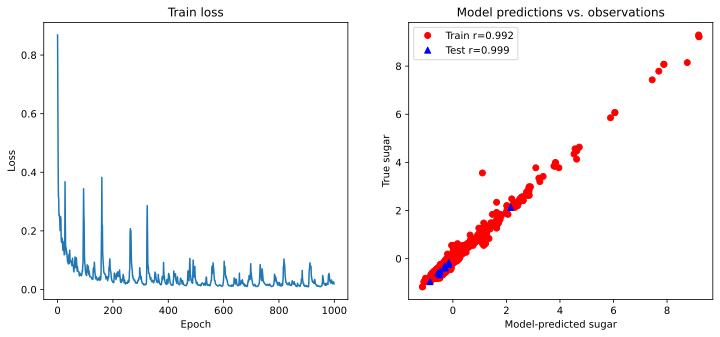

In [84]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot(losses)
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')


ax[1].plot(yHatTrain.detach(),train_labelsT,'ro')
ax[1].plot(yHatTest.detach(),test_labelsT,'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs. observations')

# correlations between predictions and outputs
corrTrain = np.corrcoef(yHatTrain.detach().T,train_labelsT.T)[1,0]
corrTest  = np.corrcoef(yHatTest.detach().T, test_labelsT.T)[1,0]
ax[1].legend([ f'Train r={corrTrain:.3f}',f'Test r={corrTest:.3f}' ])

plt.show()